# **View a specific instance and test correctness of features**

In [1]:
###############################################################################
# Import packages
###############################################################################
import os
import time
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from scipy.spatial.distance import cdist
import gurobipy as gp
from gurobipy import GRB
from scipy.stats import skew
import math
import itertools
from sklearn.cluster import DBSCAN

# Load functions
from helperfunctions_data_generation import distance, fun_load_file, solve_tsp, plot_tsp, fun_cluster_features

# Load data
df_final = fun_load_file(subfolder_path='..\\..\\01_data\\01_TSP', name='tsp_instances_j_updated.xlsx')
df_final = df_final[df_final.columns[1:]]
df_final

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,...,Centroid Distance To Depot Ratio,Distance To Closest Other Cluster Ratio,Distance To Closest Other Centroid Ratio,Cluster Area Ratio,Cluster Density Ratio,Savings Ratio,Marginal Costs Ratio,Shapley Value,SHAPO,Percentage Error
0,1,6,11.757432,50.848731,2.380844,66.016752,17.832253,29.874328,36.418450,42.990573,...,0.885295,1.199919,1.199889,1.199907,0.011512,0.022796,0.021584,6.805996,6.847093,6.038307e-03
1,1,6,83.228495,41.537025,2.380844,66.016752,84.472480,33.588825,42.487567,51.532130,...,1.573524,0.000403,0.000554,0.000465,5.942439,2.161204,2.365312,73.361446,72.126416,1.683486e-02
2,1,6,33.032921,29.876631,2.380844,66.016752,47.388376,9.140981,29.874328,32.182303,...,0.885295,1.199919,1.199889,1.199907,0.011512,0.186036,0.176144,21.568006,21.751330,8.499829e-03
3,1,6,42.131509,30.755973,2.380844,66.016752,53.136032,9.140981,30.003533,30.228067,...,0.885295,1.199919,1.199889,1.199907,0.011512,0.514850,0.487476,25.980268,26.403603,1.629447e-02
4,1,6,54.103013,58.267699,2.380844,66.016752,52.299433,30.003533,33.588825,35.355360,...,0.885295,1.199919,1.199889,1.199907,0.011512,0.101425,0.096032,30.191952,30.346193,5.108680e-03
5,1,6,47.123425,0.942942,2.380844,66.016752,78.971509,30.228067,32.182303,54.327300,...,0.885295,1.199919,1.199889,1.199907,0.011512,3.013690,2.853452,69.383518,69.816551,6.241154e-03
6,2,6,31.785825,86.586395,6.776273,45.042671,48.490810,11.630327,57.774257,58.162671,...,0.947017,1.091059,1.051255,0.158211,2.075572,1.150969,1.150969,36.024748,36.024748,0.000000e+00
7,2,6,64.605724,38.114935,6.776273,45.042671,58.242930,15.228980,15.849606,27.615868,...,1.026492,0.931781,0.950997,1.420894,0.462214,0.060682,0.060682,29.897177,29.897177,4.753243e-16
8,2,6,46.935271,16.892512,6.776273,45.042671,49.042600,15.241587,27.615868,43.418085,...,1.026492,1.237345,1.205683,1.420894,0.462214,2.478577,2.478577,36.012036,36.012036,0.000000e+00
9,2,6,75.879599,49.255391,6.776273,45.042671,69.231616,15.849606,30.632110,43.418085,...,1.026492,0.885456,0.923953,1.420894,0.462214,1.820778,1.820778,46.204531,46.204531,3.075641e-16


**Extract necessary information out of the tsp instance**

In [6]:
# Define instance id and get the data frame of the instance
instance_id = 2
tsp_instance = df_final[df_final['Instance ID'] == instance_id]
tsp_instance.index = np.arange(start=1, stop=len(tsp_instance)+1)

# Get instance coordinates and cluster assignments
coord = [(tsp_instance.iloc[0]['X Depot'], tsp_instance.iloc[0]['Y Depot'])] + [(tsp_instance.iloc[i]['X'], tsp_instance.iloc[i]['Y']) for i in range(len(tsp_instance))]
assignments = tsp_instance['Cluster']

# Get indices of core points
core_points_mask = np.zeros_like(assignments, dtype=bool) # Create list with same length as assignments containing only zero/False values
core_point_indices = np.where(tsp_instance['Core Point'] == True)[0]

# Solve TSP
sequence, total_costs = solve_tsp(coord)

**Distance features**

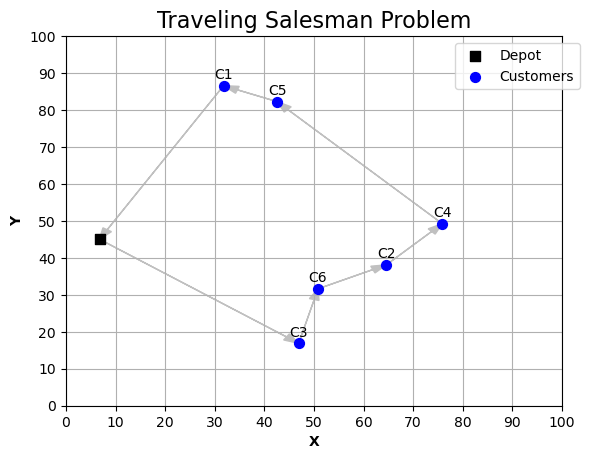

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,4th CCD,5th CCD,6th CCD,7th CCD,8th CCD,9th CCD,10th CCD,Mean Distance To Other Customers,Gravity Center Distance
1,2,6,31.785825,86.586395,6.776273,45.042671,48.490810,11.630327,57.774257,58.162671,58.537408,71.321406,100000,100000,100000,100000,100000,51.485214,41.159376
2,2,6,64.605724,38.114935,6.776273,45.042671,58.242930,15.228980,15.849606,27.615868,49.340085,58.537408,100000,100000,100000,100000,100000,33.314389,17.804536
3,2,6,46.935271,16.892512,6.776273,45.042671,49.042600,15.241587,27.615868,43.418085,65.520443,71.321406,100000,100000,100000,100000,100000,44.623478,34.290214
4,2,6,75.879599,49.255391,6.776273,45.042671,69.231616,15.849606,30.632110,43.418085,46.887060,57.774257,100000,100000,100000,100000,100000,38.912223,23.826093
5,2,6,42.584858,82.268367,6.776273,45.042671,51.652756,11.630327,46.887060,49.340085,51.305864,65.520443,100000,100000,100000,100000,100000,44.936756,32.884885
6,2,6,50.827016,31.628871,6.776273,45.042671,46.047779,15.228980,15.241587,30.632110,51.305864,58.162671,100000,100000,100000,100000,100000,34.114242,19.204646


Depot distances:


{'Customer 1': 48.490809524997246,
 'Customer 2': 58.242929991579956,
 'Customer 3': 49.04259959953359,
 'Customer 4': 69.23161628012642,
 'Customer 5': 51.65275607735633,
 'Customer 6': 46.04777878411249}

CLOSEST CUSTOMER DISTANCES:
- Customer 1: [11.63032654 57.77425736 58.16267106 58.53740802 71.3214063 ]; Mean: 51.48521385645533
- Customer 2: [15.22897995 15.84960607 27.61586796 49.34008545 58.53740802]; Mean: 33.31438949023955
- Customer 3: [15.24158669 27.61586796 43.41808456 65.52044348 71.3214063 ]; Mean: 44.62347779844343
- Customer 4: [15.84960607 30.63210962 43.41808456 46.88705969 57.77425736]; Mean: 38.91222346095766
- Customer 5: [11.63032654 46.88705969 49.34008545 51.3058639  65.52044348]; Mean: 44.936755809002605
- Customer 6: [15.22897995 15.24158669 30.63210962 51.3058639  58.16267106]; Mean: 34.11424224330704

Gravity Center: [52.1030487870913, 50.79107850393542]

CUSTOMER DISTANCE MATRIX:


,Customer 1,Customer 2,Customer 3,Customer 4,Customer 5,Customer 6,Mean,Gravity Center Distance
Customer 1,0.000000,58.537408,71.321406,57.774257,11.630327,58.162671,51.485214,41.159376
Customer 2,58.537408,0.000000,27.615868,15.849606,49.340085,15.228980,33.314389,17.804536
Customer 3,71.321406,27.615868,0.000000,43.418085,65.520443,15.241587,44.623478,34.290214
Customer 4,57.774257,15.849606,43.418085,0.000000,46.887060,30.632110,38.912223,23.826093
Customer 5,11.630327,49.340085,65.520443,46.887060,0.000000,51.305864,44.936756,32.884885
Customer 6,58.162671,15.228980,15.241587,30.632110,51.305864,0.000000,34.114242,19.204646


In [7]:
# Get column names
instance_features = ['Instance ID', 'Number Customers', 'X', 'Y', 'X Depot', 'Y Depot']
distance_features = ['Depot Distance', 'Closest Customer Distance (CCD)', '2nd CCD', '3rd CCD', '4th CCD', '5th CCD', '6th CCD', '7th CCD', 
                     '8th CCD', '9th CCD', '10th CCD', 'Mean Distance To Other Customers', 'Gravity Center Distance']

# Define the range for X and Y coordinates and view instance with optimal tour as well as the data frame
x_range = (0, 100)
y_range = (0, 100)
plot_tsp(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
         assignments=None, core_point_indices=None, plot_sequence=True)
display(tsp_instance[instance_features + distance_features])

# Depot distances
num_customers = len(tsp_instance)
print('Depot distances:')
display({'Customer ' + str(i): distance(coord1=coord[0], coord2=coord[i]) for i in range(1, num_customers+1)})

# Customer distance matrix and mean distance
labels = ['Customer ' + str(i) for i in range(1, num_customers+1)]
distance_matrix = pd.DataFrame(cdist(tsp_instance[['X', 'Y']], tsp_instance[['X', 'Y']], metric='euclidean'), index=labels, columns=labels)
for index in range(len(distance_matrix)):
    if (index == 0): print('CLOSEST CUSTOMER DISTANCES:')
    print('- Customer {}: {}; Mean: {}'.format(index+1, np.sort(distance_matrix.iloc[index])[1:min(num_customers, 11)], np.mean(np.sort(distance_matrix.iloc[index])[1:])))
distance_matrix['Mean'] = np.sum(distance_matrix, axis=1) / (num_customers - 1)

# Add gravity center
gravity_center = list(np.mean(tsp_instance[['X', 'Y']], axis=0))
print('\nGravity Center:', gravity_center)
gravity_center_distances = [distance(coord1=gravity_center, coord2=list(tsp_instance.iloc[customer][['X', 'Y']])) for customer in range(num_customers)]
distance_matrix['Gravity Center Distance'] = gravity_center_distances

print('\nCUSTOMER DISTANCE MATRIX:'); display(distance_matrix)

**Cluster features**

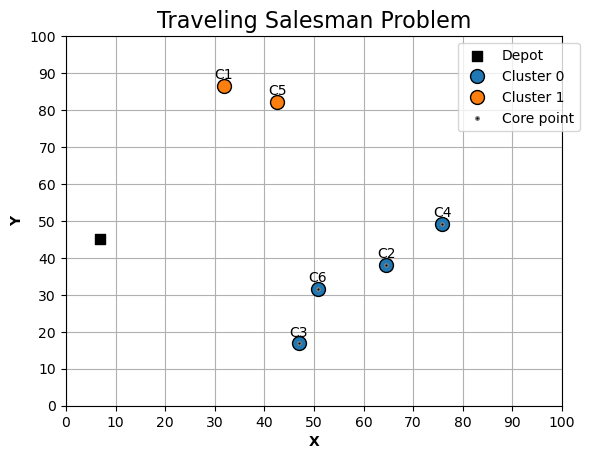

,X,Y,Depot Distance,Cluster,Core Point,Outlier,Number Clusters,Number Outliers,Cluster Size,X Centroid,Y Centroid,Centroid Distance,Centroid Distance To Depot,Distance To Closest Other Cluster,Distance To Closest Other Centroid,Cluster Area,Cluster Density
1,31.785825,86.586395,48.490810,1,0,0,2,0,2,37.185342,84.427381,5.815163,49.758083,57.774257,59.495272,91.592453,0.021836
2,64.605724,38.114935,58.242930,0,1,0,2,0,4,59.561902,33.972927,6.526589,53.933866,49.340085,53.821185,822.591421,0.004863
3,46.935271,16.892512,49.042600,0,1,0,2,0,4,59.561902,33.972927,21.240819,53.933866,65.520443,68.235032,822.591421,0.004863
4,75.879599,49.255391,69.231616,0,1,0,2,0,4,59.561902,33.972927,22.356675,53.933866,46.887060,52.290673,822.591421,0.004863
5,42.584858,82.268367,51.652756,1,0,0,2,0,2,37.185342,84.427381,5.815163,49.758083,46.887060,51.192475,91.592453,0.021836
6,50.827016,31.628871,46.047779,0,1,0,2,0,4,59.561902,33.972927,9.043940,53.933866,51.305864,54.532356,822.591421,0.004863


Cluster 0 with Customers: [2, 3, 4, 6]
    - Centroid {'X': 59.56190242129809, 'Y': 33.97292737538209}
    - Customer distances to centorid: [6.526589110908538, 21.240819491867775, 22.356675039401612, 9.043939828388616]
    - Centroid distance to depot: 53.9338658651682
    - Distance of other cluster customers to centroid: {'Customer 1': 59.49527230874034, 'Customer 5': 51.19247512259382}
Cluster 1 with Customers: [1, 5]
    - Centroid {'X': 37.18534151867773, 'Y': 84.42738076104206}
    - Customer distances to centorid: [5.815163270267025, 5.8151632702670195]
    - Centroid distance to depot: 49.75808261507224
    - Distance of other cluster customers to centroid: {'Customer 2': 53.82118505715387, 'Customer 3': 68.23503228732963, 'Customer 4': 52.290672838090416, 'Customer 6': 54.5323561161058}

CUSTOMER DISTANCE MATRIX:


,Customer 1,Customer 2,Customer 3,Customer 4,Customer 5,Customer 6,Mean,Gravity Center Distance
Customer 1,0.000000,58.537408,71.321406,57.774257,11.630327,58.162671,51.485214,41.159376
Customer 2,58.537408,0.000000,27.615868,15.849606,49.340085,15.228980,33.314389,17.804536
Customer 3,71.321406,27.615868,0.000000,43.418085,65.520443,15.241587,44.623478,34.290214
Customer 4,57.774257,15.849606,43.418085,0.000000,46.887060,30.632110,38.912223,23.826093
Customer 5,11.630327,49.340085,65.520443,46.887060,0.000000,51.305864,44.936756,32.884885
Customer 6,58.162671,15.228980,15.241587,30.632110,51.305864,0.000000,34.114242,19.204646


In [8]:
# Get column names
cluster_features = ['Cluster', 'Core Point', 'Outlier', 'Number Clusters', 'Number Outliers', 'Cluster Size', 'X Centroid', 'Y Centroid', 'Centroid Distance', 
                    'Centroid Distance To Depot', 'Distance To Closest Other Cluster', 'Distance To Closest Other Centroid', 'Cluster Area', 'Cluster Density']

# View instance as well as the data frame
plot_tsp(coord=coord, sequence=None, total_costs=None, x_range=x_range, y_range=y_range, 
         assignments=assignments, core_point_indices=core_point_indices, plot_sequence=False)
display(tsp_instance[['X', 'Y', 'Depot Distance'] + cluster_features])

# Recompute cluster features
for cluster in np.unique(tsp_instance['Cluster']):
    if (cluster == -1):
        # Compute feature for each outlier individually
        for outlier in tsp_instance[tsp_instance['Cluster'] == -1].index:
            cluster_data = centroid = list(tsp_instance.loc[outlier][['X', 'Y']])
            centroid_distances = distance(coord1=centroid, coord2=cluster_data)
            centroid_depot_distance = distance(coord1=centroid, coord2=coord[0])
            not_cluster_data = tsp_instance[tsp_instance['Cluster'] != cluster][['X', 'Y']]
            other_customers_centroid_distances = [distance(coord1=centroid, coord2=list(not_cluster_data.iloc[customer])) for customer in range(len(not_cluster_data))]

            # Print results
            print('Cluster {}: Customer {}\n    - Centroid {}'.format(int(cluster), outlier, {'X': centroid[0], 'Y': centroid[1]}))
            print('    - Customer distances to centorid: {}\n    - Centroid distance to depot: {}'.format(centroid_distances, centroid_depot_distance))
            #print('    - Distance of other cluster customers to centroid:', other_customers_centroid_distances)
    
    else: # Compute features for all other clusters
        cluster_data = tsp_instance[tsp_instance['Cluster'] == cluster][['X', 'Y']]
        centroid = list(np.mean(cluster_data, axis=0))
        centroid_distances = [distance(coord1=centroid, coord2=list(cluster_data.iloc[customer])) for customer in range(len(cluster_data))]
        centroid_depot_distance = distance(coord1=centroid, coord2=coord[0])
        not_cluster_data = tsp_instance[tsp_instance['Cluster'] != cluster][['X', 'Y']]
        other_customers_centroid_distances = [distance(coord1=centroid, coord2=list(not_cluster_data.iloc[customer])) for customer in range(len(not_cluster_data))]

        # Print results
        print('Cluster {} with Customers: {}\n    - Centroid {}'.format(int(cluster), [i for i in cluster_data.index], {'X': centroid[0], 'Y': centroid[1]}))
        print('    - Customer distances to centorid: {}\n    - Centroid distance to depot: {}'.format(centroid_distances, centroid_depot_distance))
        print('    - Distance of other cluster customers to centroid:', {'Customer ' + str(not_cluster_data.index[i]): other_customers_centroid_distances[i] for i in range(len(not_cluster_data))})

print('\nCUSTOMER DISTANCE MATRIX:'); display(distance_matrix)

In [9]:
x_depot = tsp_instance.iloc[0]['X Depot'] # X coordinate of depot
y_depot = tsp_instance.iloc[0]['Y Depot'] # Y coordinate of depot
df_depot = pd.DataFrame(data={'Instance ID': instance_id, 'Number Customers': num_customers, 
                                'X': x_depot, 'Y': y_depot}, index=[0])
tsp_instance = pd.concat([df_depot, tsp_instance], ignore_index=True)

tsp_instance = fun_cluster_features(data=tsp_instance, assignments=assignments, core_point_indices=core_point_indices, 
                                    features=instance_features+cluster_features, prints=True)
tsp_instance = tsp_instance.iloc[1:]

  - Cluster: 0
      Centroid: {'X': 59.56190242129809, 'Y': 33.97292737538209}
      Distances to centroid: {'Customer 2': 6.526589110908538, 'Customer 3': 21.240819491867775, 'Customer 4': 22.356675039401612, 'Customer 6': 9.043939828388616}
  - Cluster: 1
      Centroid: {'X': 37.18534151867773, 'Y': 84.42738076104206}
      Distances to centroid: {'Customer 1': 5.815163270267025, 'Customer 5': 5.8151632702670195}


,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Cluster,Core Point,Outlier,Number Clusters,Number Outliers,Cluster Size,X Centroid,Y Centroid,Centroid Distance,Centroid Distance To Depot,Distance To Closest Other Cluster,Distance To Closest Other Centroid,Cluster Area,Cluster Density
0,2,6,6.776273,45.042671,NaN,NaN,<NA>,<NA>,<NA>,2,0,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,6,31.785825,86.586395,6.776273,45.042671,1,0,0,2,0,2,37.185342,84.427381,5.815163,49.758083,57.774257,59.495272,91.592453,0.021836
2,2,6,64.605724,38.114935,6.776273,45.042671,0,1,0,2,0,4,59.561902,33.972927,6.526589,53.933866,49.340085,53.821185,822.591421,0.004863
3,2,6,46.935271,16.892512,6.776273,45.042671,0,1,0,2,0,4,59.561902,33.972927,21.240819,53.933866,65.520443,68.235032,822.591421,0.004863
4,2,6,75.879599,49.255391,6.776273,45.042671,0,1,0,2,0,4,59.561902,33.972927,22.356675,53.933866,46.887060,52.290673,822.591421,0.004863
5,2,6,42.584858,82.268367,6.776273,45.042671,1,0,0,2,0,2,37.185342,84.427381,5.815163,49.758083,46.887060,51.192475,91.592453,0.021836
6,2,6,50.827016,31.628871,6.776273,45.042671,0,1,0,2,0,4,59.561902,33.972927,9.043940,53.933866,51.305864,54.532356,822.591421,0.004863


**Statistics and costs features**

Total costs: 202.37096806419873
Optimal solution: [(0, 3), (1, 0), (2, 4), (3, 6), (4, 5), (5, 1), (6, 2)]


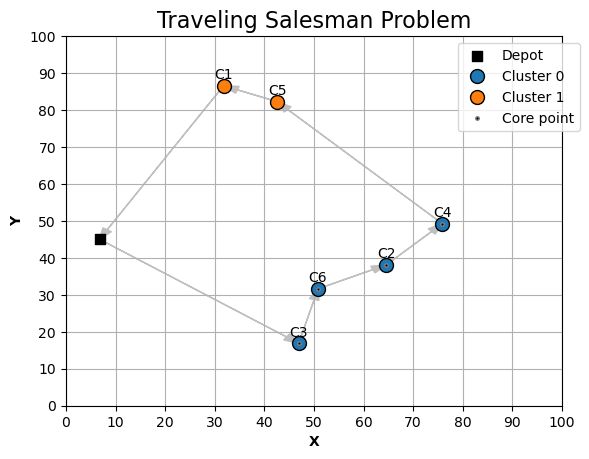

,X,Y,Depot Distance,X Mean,Y Mean,X Std,Y Std,X Max,Y Max,X Min,Y Min,Correlation,Skewness X,Skewness Y,Savings,Marginal Costs,Total Costs,Shapley Value
1,31.785825,86.586395,48.490810,52.103049,50.791079,14.453148,25.662782,75.879599,86.586395,31.785825,16.892512,-0.459339,0.331587,0.286208,8.468380,8.468380,202.370968,36.024748
2,64.605724,38.114935,58.242930,52.103049,50.791079,14.453148,25.662782,75.879599,86.586395,31.785825,16.892512,-0.459339,0.331587,0.286208,0.446476,0.446476,202.370968,29.897177
3,46.935271,16.892512,49.042600,52.103049,50.791079,14.453148,25.662782,75.879599,86.586395,31.785825,16.892512,-0.459339,0.331587,0.286208,18.236408,18.236408,202.370968,36.012036
4,75.879599,49.255391,69.231616,52.103049,50.791079,14.453148,25.662782,75.879599,86.586395,31.785825,16.892512,-0.459339,0.331587,0.286208,13.396580,13.396580,202.370968,46.204531
5,42.584858,82.268367,51.652756,52.103049,50.791079,14.453148,25.662782,75.879599,86.586395,31.785825,16.892512,-0.459339,0.331587,0.286208,0.743129,0.743129,202.370968,31.981149
6,50.827016,31.628871,46.047779,52.103049,50.791079,14.453148,25.662782,75.879599,86.586395,31.785825,16.892512,-0.459339,0.331587,0.286208,2.854699,2.854699,202.370968,22.251327


RECOMPUTED STATISTICS:
X mean: 52.1030487870913
Y mean: 50.79107850393542
X std: 14.453148295650003
Y std: 25.66278199183151
X max: 75.87959930424171
Y max: 86.58639452530512
X min: 31.78582455643145
Y min: 16.89251194102375
X skew: 0.33158719013172966
Y skew: 0.28620759991689976
X and Y coordinates correlation: -0.4593391907028902


In [10]:
# Get column names
statistical_features = ['X Mean', 'Y Mean', 'X Std', 'Y Std', 'X Max', 'Y Max', 'X Min', 'Y Min', 'Correlation', 'Skewness X', 'Skewness Y']
cost_features = ['Savings', 'Marginal Costs', 'Total Costs', 'Shapley Value']

# View instance with optimal tour and display the data frame
plot_tsp(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
         assignments=assignments, core_point_indices=core_point_indices, plot_sequence=True, print_sequence=True)
display(tsp_instance[['X', 'Y', 'Depot Distance'] + statistical_features + cost_features])

# Recompute statistics
print('RECOMPUTED STATISTICS:')
statistics = [np.mean, np.std, np.max, np.min, skew]
for statistic in statistics:
    for column in ['X', 'Y']:
        print('{} {}: {}'.format(column, str(statistic.__name__), statistic((tsp_instance[column]))))

print('X and Y coordinates correlation:', np.corrcoef(tsp_instance['X'], tsp_instance['Y'])[0, 1])

**Ratio features**

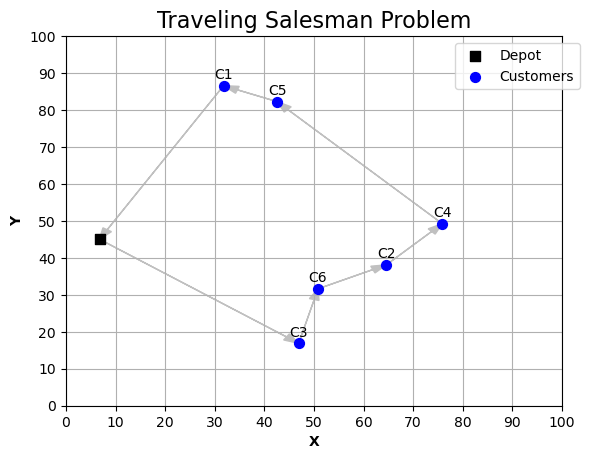

,X,Y,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,4th CCD,5th CCD,6th CCD,7th CCD,...,Mean Distance To Other Customers,Gravity Center Distance,Centroid Distance,Centroid Distance To Depot,Distance To Closest Other Cluster,Distance To Closest Other Centroid,Cluster Area,Cluster Density,Savings,Marginal Costs
1,31.785825,86.586395,48.490810,11.630327,57.774257,58.162671,58.537408,71.321406,100000.0,100000.0,...,51.485214,41.159376,5.815163,49.758083,57.774257,59.495272,91.592453,0.021836,8.468380,8.468380
2,64.605724,38.114935,58.242930,15.228980,15.849606,27.615868,49.340085,58.537408,100000.0,100000.0,...,33.314389,17.804536,6.526589,53.933866,49.340085,53.821185,822.591421,0.004863,0.446476,0.446476
3,46.935271,16.892512,49.042600,15.241587,27.615868,43.418085,65.520443,71.321406,100000.0,100000.0,...,44.623478,34.290214,21.240819,53.933866,65.520443,68.235032,822.591421,0.004863,18.236408,18.236408
4,75.879599,49.255391,69.231616,15.849606,30.632110,43.418085,46.887060,57.774257,100000.0,100000.0,...,38.912223,23.826093,22.356675,53.933866,46.887060,52.290673,822.591421,0.004863,13.396580,13.396580
5,42.584858,82.268367,51.652756,11.630327,46.887060,49.340085,51.305864,65.520443,100000.0,100000.0,...,44.936756,32.884885,5.815163,49.758083,46.887060,51.192475,91.592453,0.021836,0.743129,0.743129
6,50.827016,31.628871,46.047779,15.228980,15.241587,30.632110,51.305864,58.162671,100000.0,100000.0,...,34.114242,19.204646,9.043940,53.933866,51.305864,54.532356,822.591421,0.004863,2.854699,2.854699


,X,Y,Depot Distance Ratio,Closest Customer Distance (CCD) Ratio,2nd CCD Ratio,3rd CCD Ratio,4th CCD Ratio,5th CCD Ratio,6th CCD Ratio,7th CCD Ratio,...,Mean Distance To Other Customers Ratio,Gravity Center Distance Ratio,Centroid Distance Ratio,Centroid Distance To Depot Ratio,Distance To Closest Other Cluster Ratio,Distance To Closest Other Centroid Ratio,Cluster Area Ratio,Cluster Density Ratio,Savings Ratio,Marginal Costs Ratio
1,31.785825,86.586395,0.901572,0.822805,1.786828,1.381608,1.087730,1.118365,1.0,1.0,...,1.248700,1.459813,0.492822,0.947017,1.091059,1.051255,0.158211,2.075572,1.150969,1.150969
2,64.605724,38.114935,1.082889,1.077398,0.490193,0.655993,0.916827,0.917904,1.0,1.0,...,0.807993,0.631479,0.553114,1.026492,0.931781,0.950997,1.420894,0.462214,0.060682,0.060682
3,46.935271,16.892512,0.911831,1.078289,0.854097,1.031362,1.217487,1.118365,1.0,1.0,...,1.082278,1.216182,1.800111,1.026492,1.237345,1.205683,1.420894,0.462214,2.478577,2.478577
4,75.879599,49.255391,1.287198,1.121305,0.947382,1.031362,0.871246,0.905937,1.0,1.0,...,0.943760,0.845048,1.894678,1.026492,0.885456,0.923953,1.420894,0.462214,1.820778,1.820778
5,42.584858,82.268367,0.960361,0.822805,1.450112,1.172034,0.953355,1.027402,1.0,1.0,...,1.089877,1.166339,0.492822,0.947017,0.885456,0.904549,0.158211,2.075572,0.101001,0.101001
6,50.827016,31.628871,0.856149,1.077398,0.471388,0.727641,0.953355,0.912028,1.0,1.0,...,0.827392,0.681138,0.766453,1.026492,0.968904,0.963563,1.420894,0.462214,0.387993,0.387993


In [13]:
# Get column names
ratio_features = ['Depot Distance', 'Closest Customer Distance (CCD)', '2nd CCD', '3rd CCD', '4th CCD', '5th CCD', '6th CCD', '7th CCD', '8th CCD', '9th CCD', '10th CCD', 
                  'Mean Distance To Other Customers', 'Gravity Center Distance', 'Centroid Distance', 'Centroid Distance To Depot', 'Distance To Closest Other Cluster', 
                  'Distance To Closest Other Centroid', 'Cluster Area', 'Cluster Density', 'Savings', 'Marginal Costs']

# View instance with optimal tour and display the data frame
plot_tsp(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
         assignments=None, core_point_indices=None, plot_sequence=True)
display(tsp_instance[['X', 'Y'] + ratio_features])
display(tsp_instance[['X', 'Y'] + [i + ' Ratio' for i in ratio_features]])

In [14]:
feature = '5th CCD'
mean = np.mean(tsp_instance[feature])
ratio = np.array(tsp_instance[feature] / mean)
for i in range(num_customers): print('Customer {}: {} / {} = {}'.format(i+1, tsp_instance.iloc[i][feature], mean, ratio[i]))

Customer 1: 71.32140630236029 / 63.772932086667915 = 1.1183648605874659
Customer 2: 58.53740802133113 / 63.772932086667915 = 0.9179036639208988
Customer 3: 71.32140630236029 / 63.772932086667915 = 1.1183648605874659
Customer 4: 57.77425735797532 / 63.772932086667915 = 0.9059369777676155
Customer 5: 65.52044347590456 / 63.772932086667915 = 1.02740208630931
Customer 6: 58.16267106007592 / 63.772932086667915 = 0.9120275508272443
